In [15]:
import os

import numpy as np
import matplotlib.pyplot as plt
import librosa
import torch
import torch.nn as torch_nn
import torchaudio

class Spectrogram(torch_nn.Module):
    """ Spectrogram front-end
    """
    def __init__(self, fl, fs, fn, sr, is_log, is_cmvn,
                 with_emphasis=False):
        """ Initialize STFT
        
        Para:
        -----
          fl: int, frame length, (number of waveform points)
          fs: int, frame shift, (number of waveform points)
          fn: int, FFT points
          sr: int, sampling rate (Hz)
          with_emphasis: bool, (default True), whether pre-emphaze input wav
          with_delta: bool, (default False), whether use delta and delta-delta
        
        """
        super(Spectrogram, self).__init__()
        self.fl = fl
        self.fs = fs
        self.fn = fn
        self.sr = sr
        self.is_log = is_log
        self.is_cmvn = is_cmvn
        
        # opts
        self.with_emphasis = with_emphasis
        self.mask = torchaudio.transforms.FrequencyMasking(fn//(5*2))

        self.dim = [1]
        self.eps = 1e-10
        return
    
    def forward(self, x, is_mask):
        """
        
        input:
        ------
         x: tensor(batch, length), where length is waveform length
        
        output:
        -------
         lfcc_output: tensor(batch, frame_num, dim_num)
        """
        # pre-emphsis 
        if self.with_emphasis:
            x[:, 1:] = x[:, 1:]  - 0.97 * x[:, 0:-1]
        
        # STFT
        x_stft = torch.stft(x, self.fn, self.fs, self.fl, 
                            window=torch.hamming_window(self.fl).to(x.device), 
                            onesided=True, pad_mode="constant", return_complex=False)        
         
        sp_amp = torch.norm(x_stft, 2, -1).pow(2).permute(0, 2, 1).contiguous()
        
        if self.is_log:
            
            sp_amp = torch.log10(sp_amp+torch.finfo(torch.float32).eps)

        if self.is_cmvn:
            sp_amp = (sp_amp - sp_amp.mean(self.dim, keepdim=True)) / (self.eps + sp_amp.std(self.dim, keepdim=True))

        if is_mask:
            sp_amp = self.mask(sp_amp.permute(0, 2, 1)).permute(0, 2, 1)   

        return sp_amp

In [26]:
def display_multiple_img(images, sr, rows = 3, cols=2,):
    figure, ax = plt.subplots(nrows=rows,ncols=cols )
    for ind, img in enumerate(images):
        ax.ravel()[ind].imshow(img)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'fig/{sr}.png')


hop = 4
sr = 16000

base_dir = "./asv"
spoof_dir = os.path.join(base_dir, 'spoof')
bonafide_dir = os.path.join(base_dir, 'bonafide')

spoof_files = ['PA_E_0136321', 'PA_E_0136258', 'PA_E_0135766']
bonafide_files = ['PA_E_0135251', 'PA_E_0135541', 'PA_E_0136967']

ns = [256, 512, 1024, 2048, 4096, 8192]

In [145]:
def _get_spec(n_fft):
    hop = 8
    sr = 16000
    s = librosa.load(os.path.join(spoof_dir, 'PA_E_0136321.flac'), sr=16000)[0]
    b = librosa.load(os.path.join(bonafide_dir, 'PA_E_0135251.flac'), sr=16000)[0]
    s = s[None, :]
    b = b[None, :]
    s = torch.from_numpy(s)
    b = torch.from_numpy(b)
    stft = Spectrogram(n_fft, n_fft // hop, n_fft, sr, False, False)
    s = stft.forward(s, is_mask=False).numpy()[0]
    b = stft.forward(b, is_mask=False).numpy()[0]
    return s, b

In [146]:
s, b = _get_spec(512)

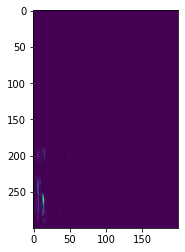

In [147]:
plt.imshow(b[:300, :200])

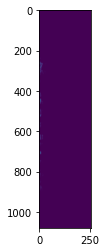

In [148]:
plt.imshow(s[:, :])

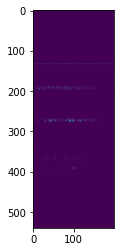

In [169]:
s, b = _get_spec(1024)
plt.imshow(s[:, -200:])

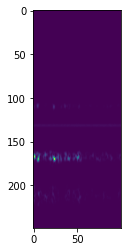

In [170]:
plt.imshow(b[:, -100:])

In [151]:
s, b = _get_spec(2048)

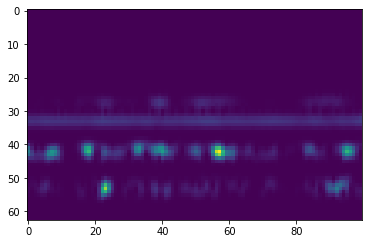

In [184]:
plt.imshow(b[:, -100:])

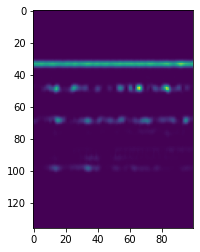

In [186]:
plt.imshow(s[:, -100:])

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [266]:
def _show_concat_img(s, b, l=800):
    con = np.concatenate([b, np.zeros([s.shape[0]-b.shape[0], s.shape[1]])])
    img = np.stack([s, con, np.zeros(s.shape)]).transpose(1,2,0)
    plt.imshow(img[:, :l])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


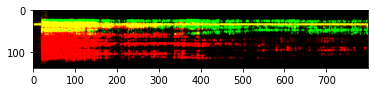

In [267]:
_show_concat_img(s, b)

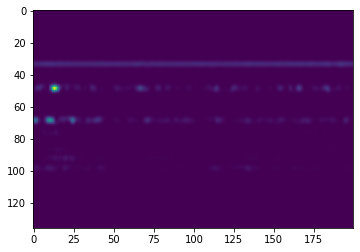

In [269]:
s, b = _get_spec(4092)
plt.imshow(s[:, -200:])

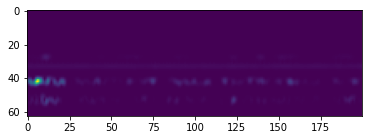

In [181]:
plt.imshow(b[:, -200:])

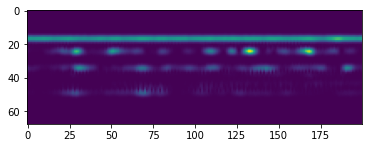

In [175]:
s, b = _get_spec(8192)
plt.imshow(s[:, -200:])

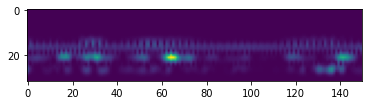

In [179]:
s, b = _get_spec(8192)
plt.imshow(b[:, -150:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


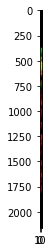

In [281]:
s, b = _get_spec(256)
_show_concat_img(s,b, 20)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


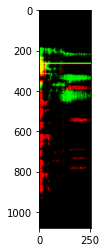

In [271]:
s, b = _get_spec(512)
_show_concat_img(s,b, 1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


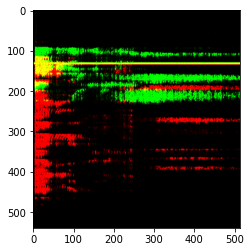

In [272]:
s, b = _get_spec(1024)
_show_concat_img(s,b, 1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


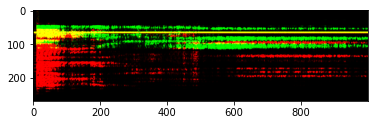

In [273]:
s, b = _get_spec(2048)
_show_concat_img(s,b, 1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


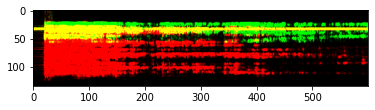

In [276]:
s, b = _get_spec(4096)
_show_concat_img(s,b, 600)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


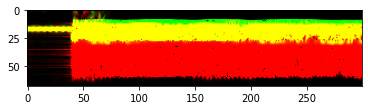

In [275]:
s, b = _get_spec(8192)
_show_concat_img(s,b, 300)